In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [4]:
import pandas as pd

In [12]:
data=pd.read_csv('excel_ree.csv')

In [13]:
data.head()

,time,<Ticker>,<DTYYYYMMDD>,<Open>,<High>,<Low>,<Close>,<Volume>
0,0,REE,20000728,1.0438,1.0438,1.0438,1.0438,1000
1,1,REE,20000731,1.0438,1.0634,1.0634,1.0634,300
2,2,REE,20000802,1.0634,1.0829,1.0829,1.0829,100
3,3,REE,20000804,1.0829,1.1025,1.1025,1.1025,200
4,4,REE,20000807,1.1025,1.1221,1.1221,1.1221,2800


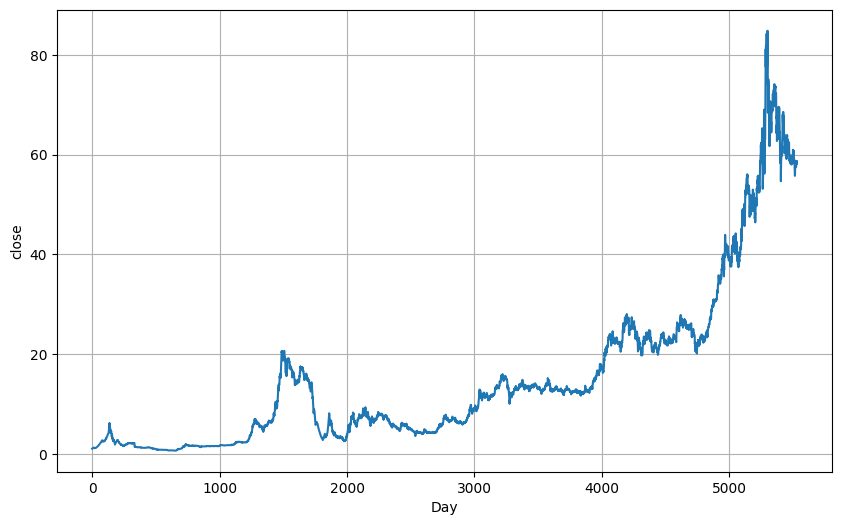

In [14]:
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('excel_ree.csv') as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')

  # Skip the first line
  next(reader)

  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[6]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time, series, xlabel='Day', ylabel='close')

In [15]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [17]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [18]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [19]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 30)                  │             930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,251 (4.89 KB)

 Trainable params: 1,251 (4.89 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.6216 - learning_rate: 1.0000e-08
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.7070 - learning_rate: 1.1220e-08
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5846 - learning_rate: 1.2589e-08
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5955 - learning_rate: 1.4125e-08
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.6761 - learning_rate: 1.5849e-08
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.6558 - learning_rate: 1.7783e-08
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5998 - learning_rate: 1.9953e-08
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.6556 - learning_rate: 2.2387e-08
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5700 - learning_rate: 2.5119e-08
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5744 - learning_rate: 2.8184e-08
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5107 - learning_rate: 3.1623e-08
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4828 - 

(1e-08, 0.001, 0.0, 100.0)

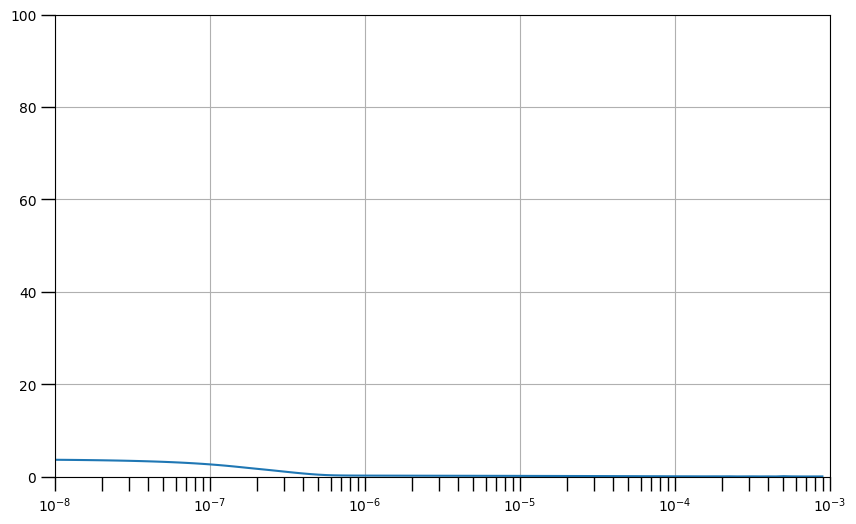

In [21]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])


In [22]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [23]:
# Set the learning rate
learning_rate = 2e-5

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.8157 - mse: 69.6990
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1221 - mse: 0.3113
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1156 - mse: 0.2926
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1147 - mse: 0.2878
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1130 - mse: 0.2820
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0997 - mse: 0.2390
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1039 - mse: 0.2602
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0957 - mse: 0.2307 
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0957 - mse: 0.2312
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0963 - mse: 0.2373
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0909 - mse: 0.2131
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0949 - mse: 0.2317
Epoch 13/100
93/93 ━━━━━━━━━━━━━━━━

In [24]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


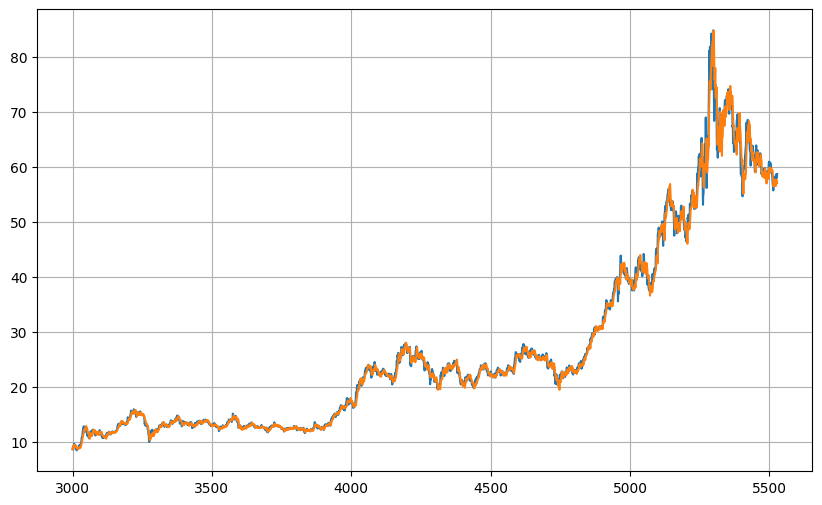

[ 8.741445  9.005479  8.728096 ... 57.63407  57.56131  57.146053]


In [25]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

In [26]:
import numpy as np

def mean_squared_error(actual, predicted):
    return np.mean((actual - predicted) ** 2)

# Tính MSE
mse = mean_squared_error(x_valid, results)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 1.4441123925246293


In [30]:
data1=pd.read_csv('REE.csv')

In [31]:
data1.head()

,time,DDMMYY,open,high,low,close,volume
0,0,5/1/2015,11.44,11.56,11.36,11.36,564940
1,1,6/1/2015,11.20,11.56,11.20,11.56,701720
2,2,7/1/2015,11.48,11.64,11.44,11.44,511170
3,3,8/1/2015,11.40,11.44,11.28,11.32,576380
4,4,9/1/2015,11.32,11.48,11.32,11.40,602250


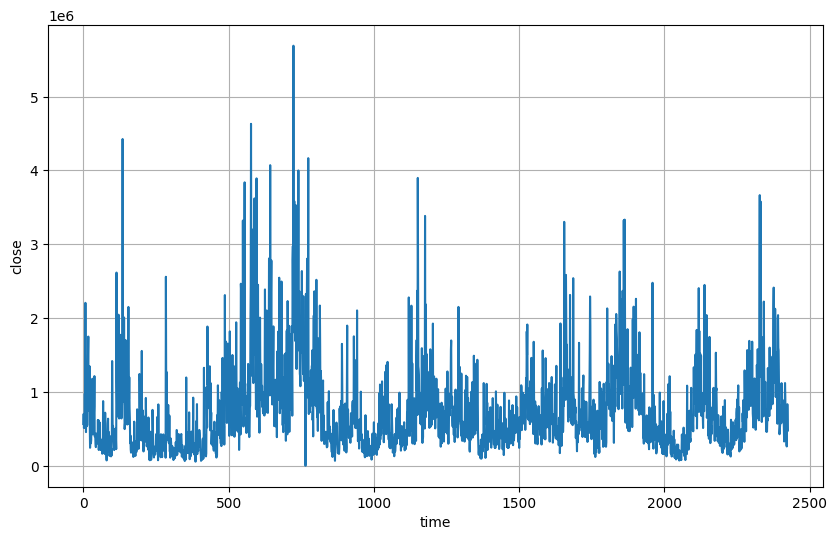

In [38]:
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('REE.csv') as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')

  # Skip the first line
  next(reader)

  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[6]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time, series, xlabel='time', ylabel='close')

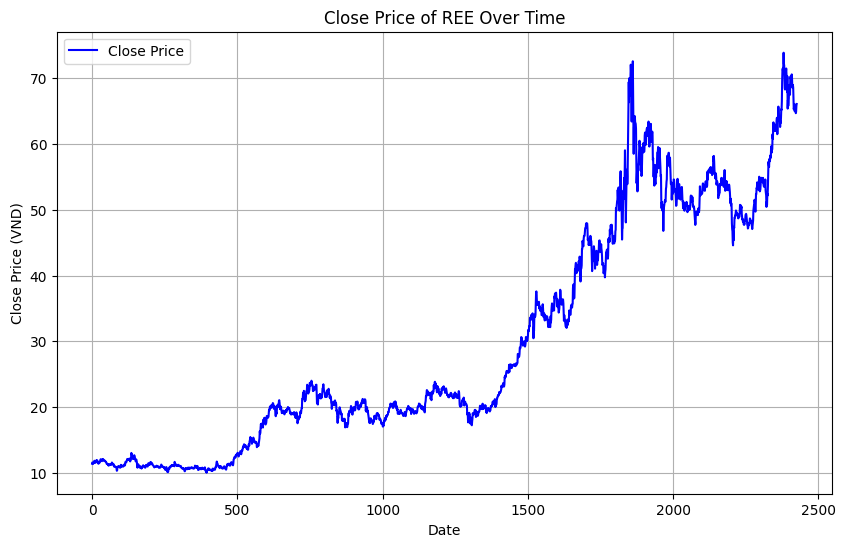

In [39]:


# Bước 4: Vẽ đồ thị giá Close theo thời gian
plt.figure(figsize=(10,6))
plt.plot(data1['time'], data1['close'], label='Close Price', color='blue')

# Thiết lập tiêu đề và nhãn trục
plt.title('Close Price of REE Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.grid(True)
plt.legend()

# Hiển thị đồ thị
plt.show()

In [53]:
# Define the split time
split_time = 2300

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [50]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 700

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [51]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 30)                  │             930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │             310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,251 (4.89 KB)

 Trainable params: 1,251 (4.89 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 459551.1250 - learning_rate: 1.0000e-08
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 307305.8125 - learning_rate: 1.1220e-08
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 293499.7812 - learning_rate: 1.2589e-08
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 309206.3125 - learning_rate: 1.4125e-08
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 306829.4688 - learning_rate: 1.5849e-08
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 303872.1250 - learning_rate: 1.7783e-08
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 301759.2188 - learning_rate: 1.9953e-08
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 317576.0312 - learning_rate: 2.2387e-08
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 311056.1875 - learning_rate: 2.5119e-08
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 301525.5312 - learning_rate: 2.8184e-08
Epoch 11

(1e-08, 0.001, 0.0, 100.0)

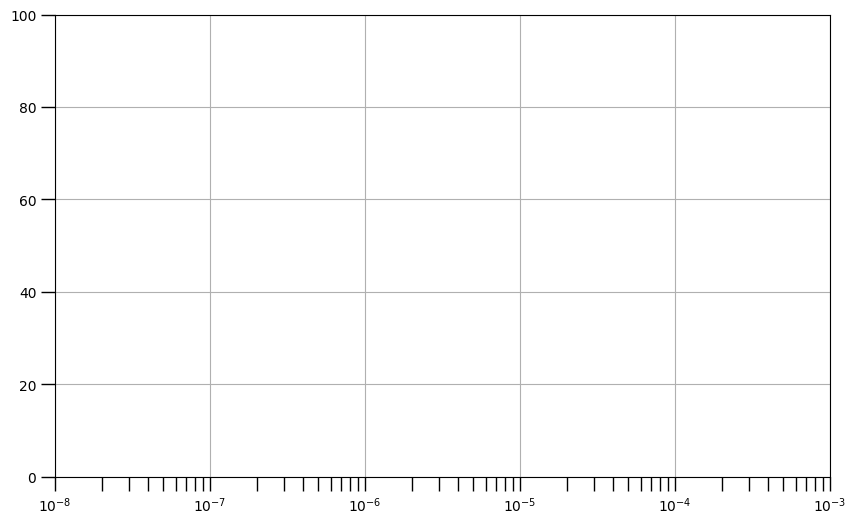

In [46]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])


In [43]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [44]:
# Set the learning rate
learning_rate = 2e-5

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9816020992.0000 - mse: 1306756586578475220992.0000
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 737035.3750 - mse: 962314436608.0000
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 746586.1875 - mse: 961844805632.0000
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 727087.8750 - mse: 904912633856.0000
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 730066.5000 - mse: 915473039360.0000
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 731746.0625 - mse: 938323476480.0000
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 722607.7500 - mse: 940137578496.0000
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 739780.6250 - mse: 979297370112.0000 
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 727607.2500 - mse: 890085572608.0000
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 734727.3750 - mse: 979432112128.0000 
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 725613.0000 - mse: 927233343488.0000
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

In [47]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


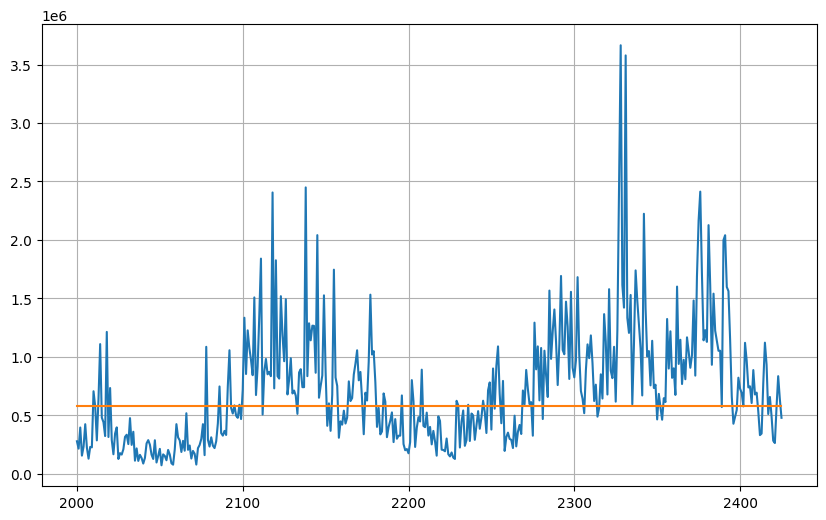

[580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6
 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6
 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6
 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6
 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6
 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6
 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6
 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6
 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6
 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6
 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6
 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6
 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6 580380.6
 580380.6 580380.6 580380.6 580380.6 580380.6 58038

In [48]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

In [49]:
import numpy as np

def mean_squared_error(actual, predicted):
    return np.mean((actual - predicted) ** 2)

# Tính MSE
mse = mean_squared_error(x_valid, results)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 276477903939.8372
